In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### **Data visualization**

Importing all necessary libraries and increase plot sizes:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(15, 8)})

In [8]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Let's look on what titanic dataset contain:

In [9]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Check missing values in train and test datasets:

In [11]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

As we see age, cabin, embarked columns in train dataset and Age, Cabin, Fare columns have missing values


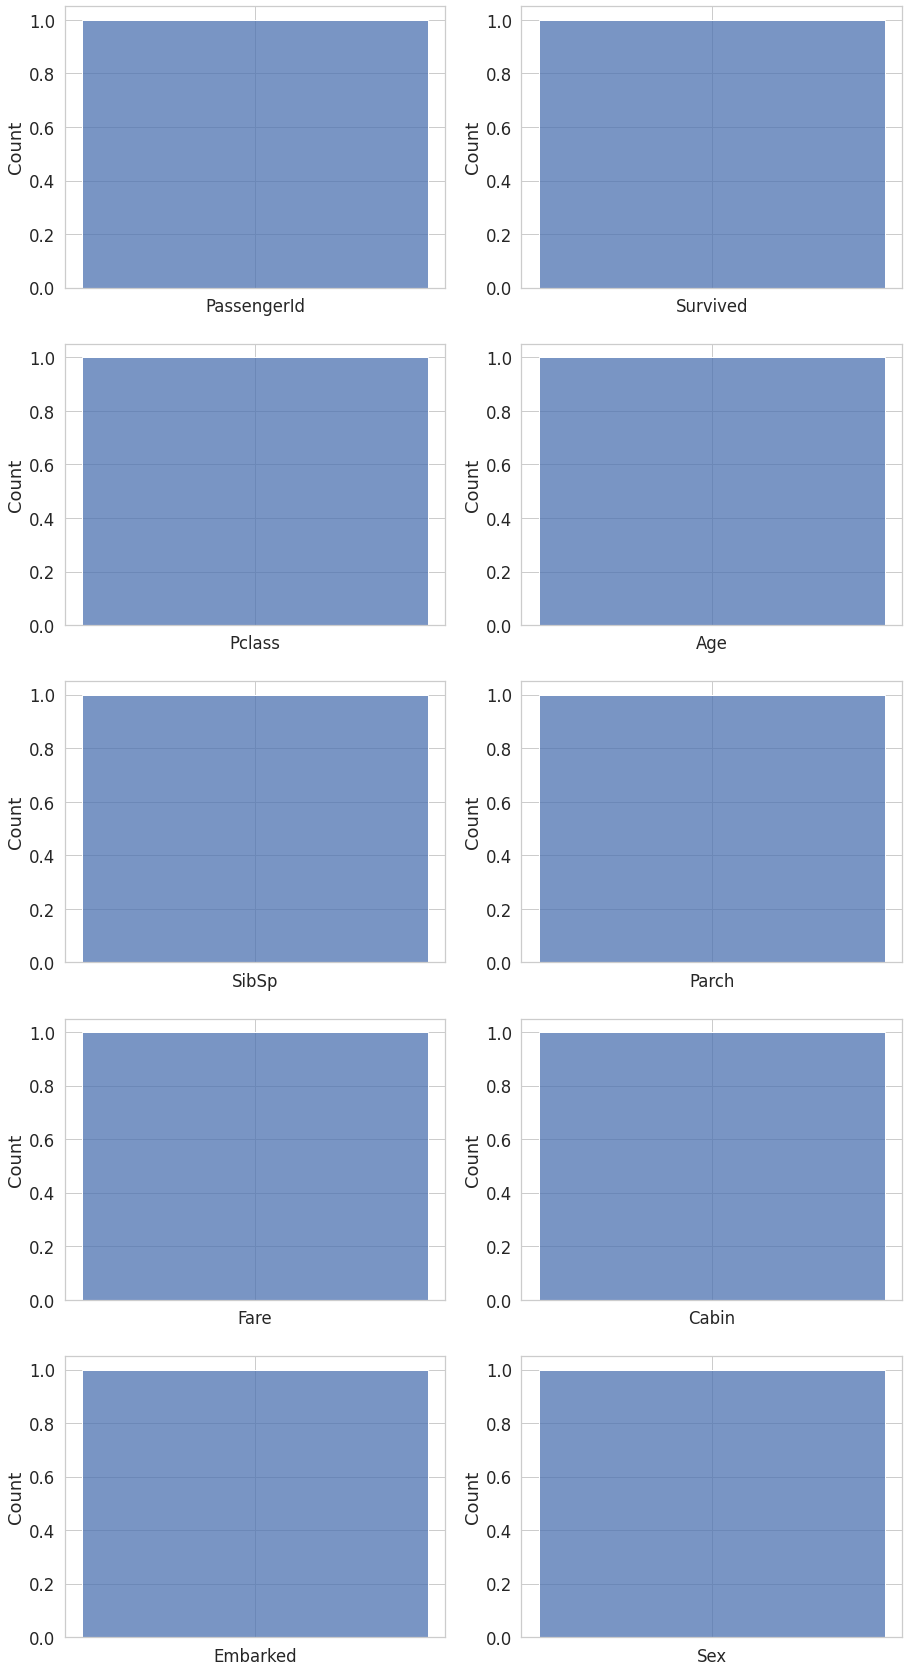

In [13]:
columns_to_plot = train_data.select_dtypes(exclude='object').columns.tolist() + ['Cabin', 'Embarked', 'Sex']
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 30))
index = 0
for axes_row in axes:
    for axis in axes_row:
        sns.histplot(columns_to_plot[index], ax=axis, kde=False)
        index += 1

**Let's display correlation matrix:**

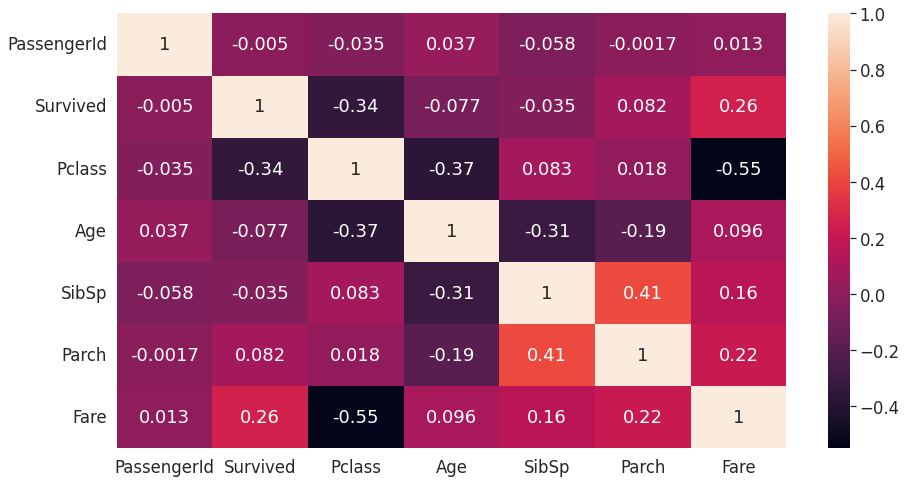

In [14]:
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix, annot=True)
pass

# Data processing

Let's 

In [15]:
data = [train_data, test_data]

for i in range(2):
    data[i]['TicketLength'] = data[i].Ticket.apply(lambda x: len(str(x)))
    data[i]['FamilySize'] = data[i].SibSp + data[i].Parch
    data[i]['IsAlone'] = data[i].FamilySize.apply(lambda x: 0 if x > 0 else 1)
    data[i]['Mr'] = data[i].Name.apply(lambda name: 1 if 'Mr.' in name else 0)
    data[i]['Mrs'] = data[i].Name.apply(lambda name: 1 if 'Mrs.' in name else 0)
    data[i]['Miss'] = data[i].Name.apply(lambda name: 1 if 'Miss.' in name else 0)
    data[i]['Master'] = data[i].Name.apply(lambda name: 1 if 'Master' in name else 0)
    data[i].drop(['Name', 'Ticket'], axis='columns', inplace=True)

data[0].head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,TicketLength,FamilySize,IsAlone,Mr,Mrs,Miss,Master
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,9,1,0,1,0,0,0
1,2,1,1,female,38.0,1,0,71.2833,C85,C,8,1,0,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,16,0,1,0,0,1,0
3,4,1,1,female,35.0,1,0,53.1000,C123,S,6,1,0,0,1,0,0
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,6,0,1,1,0,0,0


In [16]:
sex_encoder = LabelEncoder()
data[0]['Sex'] =  sex_encoder.fit_transform(data[0]['Sex'])
data[1]['Sex'] = sex_encoder.fit_transform(data[1]['Sex'])
data[0].head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,TicketLength,FamilySize,IsAlone,Mr,Mrs,Miss,Master
0,1,0,3,1,22.0,1,0,7.2500,NaN,S,9,1,0,1,0,0,0
1,2,1,1,0,38.0,1,0,71.2833,C85,C,8,1,0,0,1,0,0
2,3,1,3,0,26.0,0,0,7.9250,NaN,S,16,0,1,0,0,1,0
3,4,1,1,0,35.0,1,0,53.1000,C123,S,6,1,0,0,1,0,0
4,5,0,3,1,35.0,0,0,8.0500,NaN,S,6,0,1,1,0,0,0


#### **FILLING MISSING VALUES**

Let's first of all fill *'Embarked'* column from train dataset (now it is data[0] variable) by the mode and *Fare* columns from test dataset (now it is data[1] column) by the mean. 

In [17]:
data[0].Embarked.fillna(data[0].Embarked.mode().iloc[0], inplace=True)
data[1].Fare.fillna(data[1].Fare.mean(), inplace=True)
data[0] = pd.get_dummies(data[0], columns=['Embarked'])
data[1] = pd.get_dummies(data[1], columns=['Embarked'])

data[0].head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,TicketLength,FamilySize,IsAlone,Mr,Mrs,Miss,Master,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,1,22.0,1,0,7.2500,NaN,9,1,0,1,0,0,0,0,0,1
1,2,1,1,0,38.0,1,0,71.2833,C85,8,1,0,0,1,0,0,1,0,0
2,3,1,3,0,26.0,0,0,7.9250,NaN,16,0,1,0,0,1,0,0,0,1
3,4,1,1,0,35.0,1,0,53.1000,C123,6,1,0,0,1,0,0,0,0,1
4,5,0,3,1,35.0,0,0,8.0500,NaN,6,0,1,1,0,0,0,0,0,1


# Imputing NAN values

In [18]:
data[0].drop(['Cabin', 'PassengerId'], axis=1, inplace=True)
data[1].drop(['Cabin', 'PassengerId'], axis=1, inplace=True)

In [19]:
data[0].head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TicketLength,FamilySize,IsAlone,Mr,Mrs,Miss,Master,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,9,1,0,1,0,0,0,0,0,1
1,1,1,0,38.0,1,0,71.2833,8,1,0,0,1,0,0,1,0,0
2,1,3,0,26.0,0,0,7.9250,16,0,1,0,0,1,0,0,0,1
3,1,1,0,35.0,1,0,53.1000,6,1,0,0,1,0,0,0,0,1
4,0,3,1,35.0,0,0,8.0500,6,0,1,1,0,0,0,0,0,1


In [20]:
knn_imput = KNNImputer(n_neighbors=3)
data[0]['Age'] = knn_imput.fit_transform(data[0])[:, 3]
data[1]['Age'] = knn_imput.fit_transform(data[1])[:, 2]

In [21]:
X_train, y_train, X_test = data[0].drop('Survived', axis=1), data[0].Survived, data[1]
scaler = StandardScaler()
features = ['Age', 'Fare', 'TicketLength']
X_train[features] = scaler.fit_transform(X_train[features])
X_test[features] = scaler.fit_transform(X_test[features])

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [23]:
import lightgbm as lgbm
import warnings 
warnings.filterwarnings('ignore')

train_set = lgbm.Dataset(X_train, y_train)
valid_set = lgbm.Dataset(X_valid, y_valid)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgbm.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50, verbose_eval=10, valid_sets=valid_set)



[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 16
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 0.390449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [27]:
acc = accuracy_score(y_valid, np.around(modelL.predict(X_valid)))
pred_res = np.around(modelL.predict(X_test))
pred_res = pd.DataFrame({
    'PassengerId' : np.arange(892, 1310, 1),
    'Survived' : pred_res})
pred_res.Survived = pred_res.Survived.astype(int)
pred_res.to_csv('res.csv', index=False)



In [28]:
acc

0.8212290502793296